In [1]:
import kagglehub
import torch
import pandas as pd
import numpy as np

In [2]:
# Download latest version
path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/kostiantynbabich/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2


In [3]:
metadata = pd.read_csv(path+"/symbols_valid_meta.csv")

In [4]:
training = (metadata.sample(frac=0.8))
evaluation = metadata[~metadata.index.isin(training.index)]

In [5]:
import matplotlib.pyplot as plt
import mplfinance as mpf

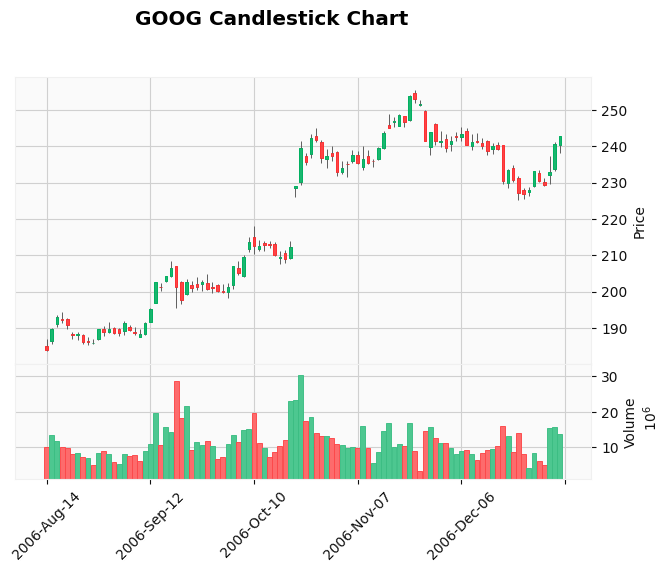

In [6]:
ticker = "GOOG"
is_etf = metadata[metadata["Symbol"]==ticker]["ETF"].item() != "N"

time_series = pd.read_csv(path + ("/etfs/" if is_etf else "/stocks/") + f"{ticker}.csv")

data_to_plot = time_series.loc[range(500, 600)]
data_to_plot['Date'] = pd.to_datetime(time_series['Date'], format='%Y-%m-%d')
data_to_plot.set_index('Date', inplace=True)



mpf.plot(data_to_plot,
         type='candle',
         style='yahoo',
         title=f"{ticker} Candlestick Chart",
         ylabel='Price',
         ylabel_lower='Volume',
         volume=True)

plt.show()

In [7]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.preprocessing import StandardScaler

def collect_all_training_samples(training_df, base_path, window_size=30, max_samples=None):
    all_samples_X = []
    all_samples_Y = []

    file_paths = []
    for idx, row in training_df.iterrows():
        ticker = row["Symbol"]
        nasdaq_ticker = row["NASDAQ Symbol"]
        is_nasdaq = row["Nasdaq Traded"] == "Y"
        is_etf = row["ETF"] != "N"

        folder = "etfs" if is_etf else "stocks"
        filename = f"{nasdaq_ticker}.csv" if is_nasdaq else f"{ticker}.csv"
        file_paths.append(os.path.join(base_path, folder, filename))

    random.shuffle(file_paths)
    
    num_files = 0
    for fp in file_paths:
        num_files += 1
        if num_files > max_samples:
            break
        
        try:
            df = pd.read_csv(fp, usecols=["Open", "Close", "Low", "High"])
            data_np = df.values.astype(np.float32)
        except (FileNotFoundError, Exception) as e:
            continue

        if np.isnan(data_np).any() or len(data_np) < window_size + 1:
            continue

        max_start_idx = len(data_np) - window_size

        if max_start_idx <= 0:
            continue

        for i in range(max_start_idx):
            input_window = data_np[i : i + window_size, :].reshape(-1)
            target_point = data_np[i + window_size, :]
            all_samples_X.append(input_window)
            all_samples_Y.append(target_point)

    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    scaled_all_samples_X = scaler_X.fit_transform(np.array(all_samples_X))
    scaled_all_samples_Y = scaler_Y.fit_transform(np.array(all_samples_Y))

    return scaled_all_samples_X, scaled_all_samples_Y, scaler_X, scaler_Y 

def batch_generator(scaled_all_samples_X, scaled_all_samples_Y, batch_size):
    num_samples = len(scaled_all_samples_X)
    indices = np.arange(num_samples)

    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i : i + batch_size]
        
        batch_X = scaled_all_samples_X[batch_indices]
        batch_Y = scaled_all_samples_Y[batch_indices]
        
        yield batch_X, batch_Y

In [8]:
from sklearn.neural_network import MLPRegressor
import time

In [9]:
start_time = time.time()
training_X, training_Y, scaler_X, scaler_Y = collect_all_training_samples(training, path, max_samples=3_000)
training_X[0], training_Y[0]
batch_gen = batch_generator(training_X, training_Y, 64)

from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 50),
                    max_iter=1,
                    solver='adam',
                    learning_rate_init=0.001,
                    random_state=42,
                    warm_start=True)

first_batch_X, first_batch_Y = next(batch_gen)
mlp.partial_fit(first_batch_X, first_batch_Y)
end_time = time.time()
print("MLPRegressor initialized.")
print(f"Initialization took {end_time-start_time}s")

MLPRegressor initialized.
Initialization took 47.94561195373535s


In [10]:
batch_size = 64
num_epochs = 10

start_time = time.time()
print("Starting training...")
for epoch in range(num_epochs):
    for batch_X, batch_Y in batch_gen:
        mlp.partial_fit(batch_X, batch_Y)

end_time = time.time()
print("Training complete.")
print(f"Training took {end_time-start_time}s")

Starting training...
Training complete.
Training took 61.834429025650024s
